<a href="https://colab.research.google.com/github/sazio/NMAs/blob/main/Data_Loader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis of Stringer Dataset 
@authors: Simone Azeglio, Chetan Dhulipalla , Khalid Saifullah 


Part of the code here has been taken from [Neuromatch Academy's Computational Neuroscience Course](https://compneuro.neuromatch.io/projects/neurons/README.html), and specifically from [this notebook](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/projects/neurons/load_stringer_spontaneous.ipynb)

# to do list

1. custom normalization: dividing by mean value per neuron
1a. downsampling: convolve then downsample by 5
2. training validation split: withhold last 20 percent of time series for testing
3. RNN for each layer: a way to capture the dynamics inside each layer instead of capturing extra dynamics from inter-layer interactions. it will be OK to compare the different RNNs. maintain same neuron count in each layer to reduce potential bias 
4. layer weight regularization: L2 
5. early stopping , dropout?

In [27]:
#%%capture
#!pip install wandb --upgrade --quiet

In [28]:
import wandb

wandb.login()

True

## Loading of Stringer spontaneous data



In [29]:
#@title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        else:
            with open(fname, "wb") as fid:
                fid.write(r.content)

In [30]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

## Exploratory Data Analysis (EDA)

In [31]:
#@title Data loading
import numpy as np
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


In [32]:
# functions 

def moving_avg(array, factor = 5):
    """Reducing the number of compontents by averaging of N = factor
    subsequent elements of array"""
    zeros_ = np.zeros((array.shape[0], 2))
    array = np.hstack((array, zeros_))

    array = np.reshape(array, (array.shape[0],  int(array.shape[1]/factor), factor))
    array = np.mean(array, axis = 2)

    return array

## Extracting Data for RNN (or LFADS)
The first problem to address is that for each layer we don't have the exact same number of neurons. We'd like to have a single RNN encoding all the different layers activities, to make it easier we can take the number of neurons ($N_{neurons} = 1131$ of the least represented class (layer) and level out each remaining class. 

In [33]:
# Extract labels from z - coordinate
from sklearn import preprocessing
x, y, z = dat['xyz']

le = preprocessing.LabelEncoder()
labels = le.fit_transform(z)
### least represented class (layer with less neurons)
n_samples = np.histogram(labels, bins=9)[0][-1]

In [34]:
### Data for LFADS / RNN 
import pandas as pd 
dataSet = pd.DataFrame(dat["sresp"])
dataSet["label"] = labels 

In [35]:
# it can be done in one loop ... 
data_ = []
for i in range(0, 9):
    data_.append(dataSet[dataSet["label"] == i].sample(n = n_samples).iloc[:,:-1].values)

dataRNN = np.zeros((n_samples*9, dataSet.shape[1]-1))
for i in range(0,9):
    
    # dataRNN[n_samples*i:n_samples*(i+1), :] = data_[i]
    ## normalized by layer
    dataRNN[n_samples*i:n_samples*(i+1), :] = data_[i]/np.mean(np.asarray(data_)[i,:,:], axis = 0)

## shuffling for training purposes

#np.random.shuffle(dataRNN)

In [36]:
#unshuffled = np.array(data_)

In [37]:
#@title Convolutions code

# convolution moving average

# kernel_length = 50
# averaging_kernel = np.ones(kernel_length) / kernel_length

# dataRNN.shape

# avgd_dataRNN = list()

# for neuron in dataRNN:
#   avgd_dataRNN.append(np.convolve(neuron, averaging_kernel))

# avg_dataRNN = np.array(avgd_dataRNN)

# print(avg_dataRNN.shape)

In [38]:
# @title Z Score Code 


# from scipy.stats import zscore


# neuron = 500

# scaled_all = zscore(avg_dataRNN)
# scaled_per_neuron = zscore(avg_dataRNN[neuron, :])

# scaled_per_layer = list()

# for layer in unshuffled:
#   scaled_per_layer.append(zscore(layer))

# scaled_per_layer = np.array(scaled_per_layer)



# plt.plot(avg_dataRNN[neuron, :])
# plt.plot(avg_dataRNN[2500, :])
# plt.figure()
# plt.plot(dataRNN[neuron, :])
# plt.figure()
# plt.plot(scaled_all[neuron, :])
# plt.plot(scaled_per_neuron)
# plt.figure()
# plt.plot(scaled_per_layer[0,neuron,:])


In [39]:
# custom normalization

normed_dataRNN = list()
for neuron in dataRNN:
    normed_dataRNN.append(neuron)# / neuron.mean())
normed_dataRNN = np.array(normed_dataRNN)

# downsampling and averaging 
#avgd_normed_dataRNN = dataRNN#
avgd_normed_dataRNN = moving_avg(dataRNN, factor=2)

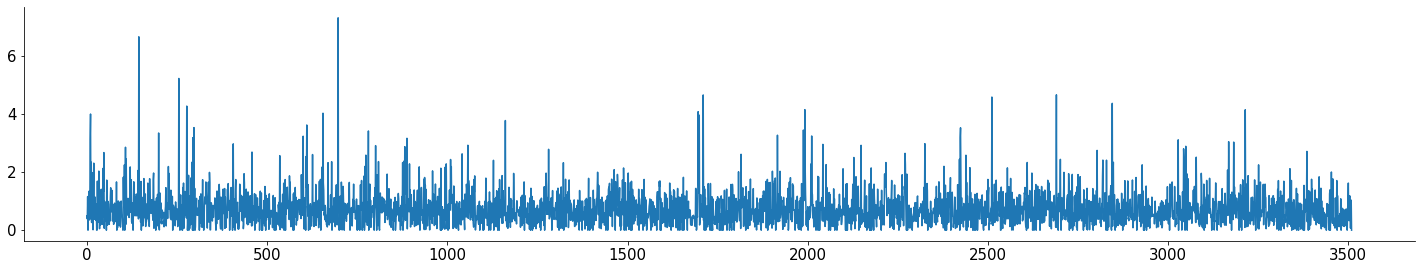

In [14]:
plt.plot(avgd_normed_dataRNN[0,:])

issue: does the individual scaling by layer introduce bias that may artificially increase performance of the network?

## Data Loader 


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
# set the seed
np.random.seed(42)

# number of neurons 
NN = dataRNN.shape[0]

In [18]:
# swapping the axes to maintain consistency with seq2seq notebook in the following code - the network takes all the neurons at a time step as input, not just one neuron

# avgd_normed_dataRNN = np.swapaxes(avgd_normed_dataRNN, 0, 1)
avgd_normed_dataRNN.shape

(10179, 3510)

In [19]:
frac = 4/5

#x1 = torch.from_numpy(dataRNN[:,:int(frac*dataRNN.shape[1])]).to(device).float().unsqueeze(0)
#x2 = torch.from_numpy(dataRNN[:,int(frac*dataRNN.shape[1]):]).to(device).float().unsqueeze(0)
#x1 = torch.from_numpy(avgd_normed_dataRNN[:1131,:]).to(device).float().unsqueeze(2)
#x2 = torch.from_numpy(avgd_normed_dataRNN[:1131,:]).to(device).float().unsqueeze(2)

n_neurs = 1131
# let's use n_neurs/10 latent components
ncomp = int(n_neurs/10)

x1_train = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,:int(frac*avgd_normed_dataRNN.shape[1])]).to(device).float().unsqueeze(2)
x2_train = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,:int(frac*avgd_normed_dataRNN.shape[1])]).to(device).float().unsqueeze(2)

x1_valid = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,int(frac*avgd_normed_dataRNN.shape[1]):]).to(device).float().unsqueeze(2)
x2_valid = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,int(frac*avgd_normed_dataRNN.shape[1]):]).to(device).float().unsqueeze(2)

NN1 = x1_train.shape[0]
NN2 = x2_train.shape[0]


In [20]:
class Net(nn.Module):
    def __init__(self, ncomp, NN1, NN2, num_layers = 1, n_comp = 50, dropout= 0,  bidi=True):
        super(Net, self).__init__()

        # play with some of the options in the RNN!
        
        self.rnn = nn.LSTM(NN1, ncomp, num_layers = num_layers, dropout = dropout,
                         bidirectional = bidi)
        """
        self.rnn = nn.RNN(NN1, ncomp, num_layers = 1, dropout = 0,
                    bidirectional = bidi, nonlinearity = 'tanh')
        self.rnn = nn.GRU(NN1, ncomp, num_layers = 1, dropout = 0,
                         bidirectional = bidi)
        """
        
        self.mlp = nn.Sequential(
                    nn.Linear(ncomp, ncomp*2),
                    nn.Mish(),
                    nn.Linear(ncomp*2, ncomp*2),
                    nn.Mish(),
                    nn.Dropout(0.25),
                    nn.Linear(ncomp*2, ncomp), 
                    nn.Mish())
        
        self.fc = nn.Linear(ncomp, NN2)

    def forward(self, x):
        x = x.permute(1, 2, 0)
        #print(x.shape)
        # h_0 = torch.zeros(2, x.size()[1], self.ncomp).to(device)
        
        y, h_n = self.rnn(x)

        #print(y.shape)
        #print(h_n.shape)
        if self.rnn.bidirectional:
          # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
          # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
            q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
        else:
            q = y
        
        q = self.mlp(q)

        # the softplus function is just like a relu but it's smoothed out so we can't predict 0
        # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
        #z = F.softplus(self.fc(q), 10)
        #print(q.shape)
        z = self.fc(q).permute(2, 0, 1)
        # print(z.shape)
        return z, q

In [21]:
sweep_config = {
    'method': 'random'
    }

metric = {
    'name': 'loss',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric

parameters_dict = {
    'optimizer': {
        'values': ['adam']
        },
    'num_layers': {
        'values': [1]
        },
    'n_comp': {
        'values': [50, 75, 100, 125, 150]
        },
    
    'dropout': {
          'values': [0.1, 0.2, 0.3, 0.5]
        },
    'weight_decay': {
          'values': [0., 1e-5, 5e-5, 1e-6]
        },
    }

sweep_config['parameters'] = parameters_dict

parameters_dict.update({
    'epochs': {
        'value': 4000}
    })

import math

parameters_dict.update({
    'learning_rate': {
        # a flat distribution between 0 and 0.1
        'distribution': 'log_uniform',
        'min': -9.9,
        'max': -5.3
    },
})

import pprint

pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'dropout': {'values': [0.1, 0.2, 0.3, 0.5]},
                'epochs': {'value': 4000},
                'learning_rate': {'distribution': 'log_uniform',
                                  'max': -5.3,
                                  'min': -9.9},
                'n_comp': {'values': [50, 75, 100, 125, 150]},
                'num_layers': {'values': [1]},
                'optimizer': {'values': ['adam']},
                'weight_decay': {'values': [0.0, 1e-05, 5e-05, 1e-06]}}}


In [22]:
sweep_id = wandb.sweep(sweep_config, project="NMAs-Small-Hidden-Dims")

Create sweep with ID: 38qam6fd
Sweep URL: https://wandb.ai/sazio/NMAs-Small-Hidden-Dims/sweeps/38qam6fd


In [23]:
# you can keep re-running this cell if you think the cost might decrease further
cost = nn.MSELoss()

# rnn_loss = 0.2372, lstm_loss = 0.2340, gru_lstm = 0.2370

## Training 

In [24]:
from tqdm import tqdm

In [25]:
def build_optimizer(network, optimizer, learning_rate, weight_decay): 
    optimizer = torch.optim.Adam(network.parameters(),
                               lr=learning_rate, weight_decay=weight_decay)
    return optimizer

def train(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config

        # loader = build_dataset(config.batch_size)
        # Net(ncomp, NN1, NN2, bidi = True).to(device)
        network = Net(ncomp, NN1, NN2, config.num_layers, config.dropout).to(device)
        optimizer = build_optimizer(network, config.optimizer, config.learning_rate, config.weight_decay)

        for epoch in range(config.epochs):
            # avg_loss = train_epoch(network, loader, optimizer)
            network.train()
            # the networkwork outputs the single-neuron prediction and the latents
            z, y = network(x1_train)

            # our cost
            loss = cost(z, x2_train)

            # train the networkwork as usual
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            with torch.no_grad():
                network.eval()
                valid_loss = cost(network(x1_valid)[0], x2_valid)

            if epoch % 50 == 0:
                with torch.no_grad():
                    network.eval()
                    valid_loss = cost(network(x1_valid)[0], x2_valid)
                    
                    print(f' iteration {epoch}, train cost {loss.item():.4f}, valid cost {valid_loss.item():.4f}')
            wandb.log({"train_loss": loss.item(), 'valid_loss': valid_loss.item(), "epoch": epoch})

In [26]:
wandb.agent(sweep_id, train, count= 50)

wandb: Agent Starting Run: l9b1er7s with config:
wandb: 	dropout: 0.5
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.00010530036728221362
wandb: 	n_comp: 100
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7076, valid cost 3.8070
 iteration 50, train cost 3.1284, valid cost 3.1865
 iteration 100, train cost 2.2769, valid cost 2.3427
 iteration 150, train cost 2.1197, valid cost 2.1903
 iteration 200, train cost 2.0963, valid cost 2.1711
 iteration 250, train cost 2.0892, valid cost 2.1671
 iteration 300, train cost 2.0854, valid cost 2.1657
 iteration 350, train cost 2.0813, valid cost 2.1647
 iteration 400, train cost 2.0793, valid cost 2.1636
 iteration 450, train cost 2.0761, valid cost 2.1620
 iteration 500, train cost 2.0727, valid cost 2.1591
 iteration 550, train cost 2.0671, valid cost 2.1537
 iteration 600, train cost 2.0582, valid cost 2.1444
 iteration 650, train cost 2.0436, valid cost 2.1282
 iteration 700, train cost 2.0235, valid cost 2.1062
 iteration 750, train cost 2.0023, valid cost 2.0844
 iteration 800, train cost 1.9792, valid cost 2.0621
 iteration 850, train cost 1.9550, valid cost 2.0382
 iteration 900, train cost 1.9332, valid cost 2.0

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.31332
valid_loss,1.47378
epoch,3999
_runtime,285
_timestamp,1628953360
_step,3999


train_loss,█▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 1nabwzeg with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 4000
wandb: 	learning_rate: 9.557916390575377e-05
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7097, valid cost 3.8090
 iteration 50, train cost 3.1941, valid cost 3.2635
 iteration 100, train cost 2.3652, valid cost 2.4428
 iteration 150, train cost 2.1432, valid cost 2.2237
 iteration 200, train cost 2.1019, valid cost 2.1821
 iteration 250, train cost 2.0913, valid cost 2.1720
 iteration 300, train cost 2.0868, valid cost 2.1685
 iteration 350, train cost 2.0838, valid cost 2.1668
 iteration 400, train cost 2.0815, valid cost 2.1658
 iteration 450, train cost 2.0793, valid cost 2.1649
 iteration 500, train cost 2.0779, valid cost 2.1640
 iteration 550, train cost 2.0756, valid cost 2.1627
 iteration 600, train cost 2.0737, valid cost 2.1607
 iteration 650, train cost 2.0700, valid cost 2.1572
 iteration 700, train cost 2.0638, valid cost 2.1508
 iteration 750, train cost 2.0536, valid cost 2.1392
 iteration 800, train cost 2.0361, valid cost 2.1195
 iteration 850, train cost 2.0110, valid cost 2.0914
 iteration 900, train cost 1.9797, valid cost 2.0

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.33606
valid_loss,1.47886
epoch,3999
_runtime,284
_timestamp,1628953648
_step,3999


train_loss,█▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 8w1cfu59 with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0024614033588095108
wandb: 	n_comp: 50
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 5e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.6907, valid cost 3.7569
 iteration 50, train cost 2.0749, valid cost 2.1670
 iteration 100, train cost 2.0448, valid cost 2.1338
 iteration 150, train cost 1.8896, valid cost 1.9693
 iteration 200, train cost 1.7907, valid cost 1.8677
 iteration 250, train cost 1.7131, valid cost 1.8030
 iteration 300, train cost 1.6900, valid cost 1.7801
 iteration 350, train cost 1.6193, valid cost 1.7355
 iteration 400, train cost 1.5728, valid cost 1.7013
 iteration 450, train cost 1.5396, valid cost 1.6930
 iteration 500, train cost 1.5027, valid cost 1.6386
 iteration 550, train cost 1.5125, valid cost 1.6381
 iteration 600, train cost 1.4407, valid cost 1.5952
 iteration 650, train cost 1.4116, valid cost 1.5746
 iteration 700, train cost 1.3976, valid cost 1.5621
 iteration 750, train cost 1.3745, valid cost 1.5495
 iteration 800, train cost 1.3518, valid cost 1.5358
 iteration 850, train cost 1.3311, valid cost 1.5224
 iteration 900, train cost 1.3410, valid cost 1.5

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.06479
valid_loss,1.27439
epoch,3999
_runtime,282
_timestamp,1628953935
_step,3999


train_loss,█▇▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▇▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: atcx8d6u with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0001436799026607388
wandb: 	n_comp: 100
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7053, valid cost 3.8053
 iteration 50, train cost 2.8305, valid cost 2.8973
 iteration 100, train cost 2.1644, valid cost 2.2462
 iteration 150, train cost 2.0963, valid cost 2.1743
 iteration 200, train cost 2.0867, valid cost 2.1675
 iteration 250, train cost 2.0829, valid cost 2.1661
 iteration 300, train cost 2.0800, valid cost 2.1651
 iteration 350, train cost 2.0778, valid cost 2.1642
 iteration 400, train cost 2.0761, valid cost 2.1631
 iteration 450, train cost 2.0734, valid cost 2.1610
 iteration 500, train cost 2.0686, valid cost 2.1564
 iteration 550, train cost 2.0576, valid cost 2.1449
 iteration 600, train cost 2.0339, valid cost 2.1192
 iteration 650, train cost 1.9966, valid cost 2.0796
 iteration 700, train cost 1.9536, valid cost 2.0369
 iteration 750, train cost 1.9148, valid cost 1.9996
 iteration 800, train cost 1.8832, valid cost 1.9675
 iteration 850, train cost 1.8613, valid cost 1.9440
 iteration 900, train cost 1.8392, valid cost 1.9

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.22994
valid_loss,1.40731
epoch,3999
_runtime,282
_timestamp,1628954225
_step,3999


train_loss,█▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: uu81bquz with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.004118851771109827
wandb: 	n_comp: 125
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7048, valid cost 3.7475
 iteration 50, train cost 2.0764, valid cost 2.1713
 iteration 100, train cost 2.0642, valid cost 2.1592
 iteration 150, train cost 2.0075, valid cost 2.0839
 iteration 200, train cost 1.9591, valid cost 2.0382
 iteration 250, train cost 1.9110, valid cost 2.0023
 iteration 300, train cost 1.8765, valid cost 1.9918
 iteration 350, train cost 1.9140, valid cost 1.9673
 iteration 400, train cost 1.8126, valid cost 1.9070
 iteration 450, train cost 1.7602, valid cost 1.8762
 iteration 500, train cost 1.7481, valid cost 1.8641
 iteration 550, train cost 1.7161, valid cost 1.8487
 iteration 600, train cost 1.6940, valid cost 1.8357
 iteration 650, train cost 1.6647, valid cost 1.8306
 iteration 700, train cost 1.7888, valid cost 1.9156
 iteration 750, train cost 1.6833, valid cost 1.8288
 iteration 800, train cost 1.6575, valid cost 1.8502
 iteration 850, train cost 1.6988, valid cost 1.8328
 iteration 900, train cost 1.6337, valid cost 1.8

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.77625
valid_loss,1.90292
epoch,3999
_runtime,283
_timestamp,1628954513
_step,3999


train_loss,▇▆▅▅▄▃▃▃▄▃▂▂▂▃▂▂▁▂█▂▂▁▁▁▁▁▁▁▆▆▅▅▅▄▄▄▄▄▄▄
valid_loss,▅▄▃▃▂▂▁▁▂▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▄▄▃▃▃▂▂▂▂▂▂▂
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: gu98cly5 with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.001977050746477505
wandb: 	n_comp: 50
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7009, valid cost 3.7787
 iteration 50, train cost 2.0786, valid cost 2.1702
 iteration 100, train cost 2.0684, valid cost 2.1608
 iteration 150, train cost 1.9938, valid cost 2.0722
 iteration 200, train cost 1.8808, valid cost 1.9602
 iteration 250, train cost 1.8011, valid cost 1.8774
 iteration 300, train cost 1.7372, valid cost 1.8293
 iteration 350, train cost 1.6870, valid cost 1.7927
 iteration 400, train cost 1.6607, valid cost 1.7880
 iteration 450, train cost 1.6227, valid cost 1.7448
 iteration 500, train cost 1.5805, valid cost 1.7163
 iteration 550, train cost 1.5453, valid cost 1.6882
 iteration 600, train cost 1.5193, valid cost 1.6665
 iteration 650, train cost 1.4777, valid cost 1.6390
 iteration 700, train cost 1.4524, valid cost 1.6256
 iteration 750, train cost 1.4225, valid cost 1.6016
 iteration 800, train cost 1.4059, valid cost 1.5889
 iteration 850, train cost 1.3706, valid cost 1.5668
 iteration 900, train cost 1.3475, valid cost 1.5

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,0.98955
valid_loss,1.28941
epoch,3999
_runtime,280
_timestamp,1628954800
_step,3999


train_loss,██▆▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▇▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: cn4vkgbo with config:
wandb: 	dropout: 0.5
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0024807559478194022
wandb: 	n_comp: 100
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7013, valid cost 3.7712
 iteration 50, train cost 2.0777, valid cost 2.1711
 iteration 100, train cost 2.0677, valid cost 2.1619
 iteration 150, train cost 2.0147, valid cost 2.0985
 iteration 200, train cost 1.9924, valid cost 2.0731
 iteration 250, train cost 1.9000, valid cost 1.9823
 iteration 300, train cost 1.8517, valid cost 1.9328
 iteration 350, train cost 1.8329, valid cost 1.9233
 iteration 400, train cost 1.7900, valid cost 1.8849
 iteration 450, train cost 1.7590, valid cost 1.8611
 iteration 500, train cost 1.7409, valid cost 1.8439
 iteration 550, train cost 1.7057, valid cost 1.8272
 iteration 600, train cost 1.6840, valid cost 1.8177
 iteration 650, train cost 1.6611, valid cost 1.8078
 iteration 700, train cost 1.6412, valid cost 1.7958
 iteration 750, train cost 1.6105, valid cost 1.7780
 iteration 800, train cost 1.5804, valid cost 1.7608
 iteration 850, train cost 1.5519, valid cost 1.7464
 iteration 900, train cost 1.5276, valid cost 1.7

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.1564
valid_loss,1.57864
epoch,3999
_runtime,282
_timestamp,1628955086
_step,3999


train_loss,██▇▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
valid_loss,█▇▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: mr41gl4p with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0007395423702276089
wandb: 	n_comp: 100
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 5e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.6963, valid cost 3.7887
 iteration 50, train cost 2.0932, valid cost 2.1795
 iteration 100, train cost 2.0742, valid cost 2.1624
 iteration 150, train cost 2.0477, valid cost 2.1330
 iteration 200, train cost 1.9468, valid cost 2.0227
 iteration 250, train cost 1.8385, valid cost 1.9116
 iteration 300, train cost 1.7677, valid cost 1.8485
 iteration 350, train cost 1.7052, valid cost 1.7950
 iteration 400, train cost 1.6544, valid cost 1.7494
 iteration 450, train cost 1.6055, valid cost 1.7055
 iteration 500, train cost 1.5669, valid cost 1.6696
 iteration 550, train cost 1.5311, valid cost 1.6351
 iteration 600, train cost 1.4959, valid cost 1.6033
 iteration 650, train cost 1.4662, valid cost 1.5766
 iteration 700, train cost 1.4404, valid cost 1.5487
 iteration 750, train cost 1.4175, valid cost 1.5275
 iteration 800, train cost 1.3990, valid cost 1.5086
 iteration 850, train cost 1.3789, valid cost 1.4909
 iteration 900, train cost 1.3621, valid cost 1.4

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.03545
valid_loss,1.17934
epoch,3999
_runtime,279
_timestamp,1628955374
_step,3999


train_loss,█▇▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▇▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: to0ktnvl with config:
wandb: 	dropout: 0.5
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0003674757375018231
wandb: 	n_comp: 150
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7048, valid cost 3.8013
 iteration 50, train cost 2.1687, valid cost 2.2469
 iteration 100, train cost 2.0835, valid cost 2.1676
 iteration 150, train cost 2.0774, valid cost 2.1639
 iteration 200, train cost 2.0712, valid cost 2.1593
 iteration 250, train cost 2.0509, valid cost 2.1399
 iteration 300, train cost 1.9720, valid cost 2.0581
 iteration 350, train cost 1.8977, valid cost 1.9815
 iteration 400, train cost 1.8598, valid cost 1.9430
 iteration 450, train cost 1.8258, valid cost 1.9069
 iteration 500, train cost 1.7839, valid cost 1.8628
 iteration 550, train cost 1.7482, valid cost 1.8309
 iteration 600, train cost 1.7150, valid cost 1.8054
 iteration 650, train cost 1.6838, valid cost 1.7797
 iteration 700, train cost 1.6493, valid cost 1.7503
 iteration 750, train cost 1.6172, valid cost 1.7233
 iteration 800, train cost 1.5882, valid cost 1.6982
 iteration 850, train cost 1.5610, valid cost 1.6748
 iteration 900, train cost 1.5352, valid cost 1.6

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.05951
valid_loss,1.26022
epoch,3999
_runtime,279
_timestamp,1628955658
_step,3999


train_loss,█▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▆▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: qq4g0im3 with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0003127226333871132
wandb: 	n_comp: 50
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7077, valid cost 3.8042
 iteration 50, train cost 2.2171, valid cost 2.2883
 iteration 100, train cost 2.0865, valid cost 2.1687
 iteration 150, train cost 2.0788, valid cost 2.1645
 iteration 200, train cost 2.0725, valid cost 2.1602
 iteration 250, train cost 2.0497, valid cost 2.1378
 iteration 300, train cost 1.9816, valid cost 2.0641
 iteration 350, train cost 1.9187, valid cost 1.9992
 iteration 400, train cost 1.8627, valid cost 1.9400
 iteration 450, train cost 1.8177, valid cost 1.8931
 iteration 500, train cost 1.7959, valid cost 1.8743
 iteration 550, train cost 1.7693, valid cost 1.8534
 iteration 600, train cost 1.7410, valid cost 1.8318
 iteration 650, train cost 1.7064, valid cost 1.8024
 iteration 700, train cost 1.6684, valid cost 1.7674
 iteration 750, train cost 1.6343, valid cost 1.7375
 iteration 800, train cost 1.6056, valid cost 1.7119
 iteration 850, train cost 1.5794, valid cost 1.6887
 iteration 900, train cost 1.5573, valid cost 1.6

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.10252
valid_loss,1.29609
epoch,3999
_runtime,279
_timestamp,1628955942
_step,3999


train_loss,█▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: v9z4wabu with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.00011175376672372573
wandb: 	n_comp: 150
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7102, valid cost 3.8097
 iteration 50, train cost 3.0949, valid cost 3.1565
 iteration 100, train cost 2.2979, valid cost 2.3605
 iteration 150, train cost 2.1244, valid cost 2.1953
 iteration 200, train cost 2.0953, valid cost 2.1707
 iteration 250, train cost 2.0879, valid cost 2.1670
 iteration 300, train cost 2.0838, valid cost 2.1657
 iteration 350, train cost 2.0812, valid cost 2.1649
 iteration 400, train cost 2.0790, valid cost 2.1640
 iteration 450, train cost 2.0766, valid cost 2.1626
 iteration 500, train cost 2.0731, valid cost 2.1604
 iteration 550, train cost 2.0687, valid cost 2.1566
 iteration 600, train cost 2.0602, valid cost 2.1492
 iteration 650, train cost 2.0441, valid cost 2.1339
 iteration 700, train cost 2.0189, valid cost 2.1091
 iteration 750, train cost 1.9939, valid cost 2.0835
 iteration 800, train cost 1.9693, valid cost 2.0578
 iteration 850, train cost 1.9465, valid cost 2.0326
 iteration 900, train cost 1.9278, valid cost 2.0

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.31913
valid_loss,1.46665
epoch,3999
_runtime,280
_timestamp,1628956228
_step,3999


train_loss,█▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: sgu9nx04 with config:
wandb: 	dropout: 0.5
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0007974986621416106
wandb: 	n_comp: 50
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.6975, valid cost 3.7879
 iteration 50, train cost 2.0917, valid cost 2.1789
 iteration 100, train cost 2.0768, valid cost 2.1667
 iteration 150, train cost 2.0726, valid cost 2.1638
 iteration 200, train cost 2.0442, valid cost 2.1309
 iteration 250, train cost 2.0057, valid cost 2.0886
 iteration 300, train cost 1.9931, valid cost 2.0761
 iteration 350, train cost 1.9379, valid cost 2.0259
 iteration 400, train cost 1.8807, valid cost 1.9666
 iteration 450, train cost 1.8425, valid cost 1.9262
 iteration 500, train cost 1.8004, valid cost 1.8895
 iteration 550, train cost 1.7761, valid cost 1.8699
 iteration 600, train cost 1.7499, valid cost 1.8510
 iteration 650, train cost 1.7171, valid cost 1.8293
 iteration 700, train cost 1.6866, valid cost 1.8075
 iteration 750, train cost 1.6537, valid cost 1.7835
 iteration 800, train cost 1.6217, valid cost 1.7611
 iteration 850, train cost 1.5947, valid cost 1.7418
 iteration 900, train cost 1.5731, valid cost 1.7

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.07456
valid_loss,1.46309
epoch,3999
_runtime,280
_timestamp,1628956512
_step,3999


train_loss,█▇▇▇▆▆▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▇▇▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 7fsyrlpl with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0004338165764738738
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 5e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7098, valid cost 3.8065
 iteration 50, train cost 2.1356, valid cost 2.2170
 iteration 100, train cost 2.0812, valid cost 2.1666
 iteration 150, train cost 2.0756, valid cost 2.1633
 iteration 200, train cost 2.0674, valid cost 2.1562
 iteration 250, train cost 2.0282, valid cost 2.1115
 iteration 300, train cost 1.9129, valid cost 1.9847
 iteration 350, train cost 1.8275, valid cost 1.9005
 iteration 400, train cost 1.7749, valid cost 1.8526
 iteration 450, train cost 1.7203, valid cost 1.8073
 iteration 500, train cost 1.6771, valid cost 1.7687
 iteration 550, train cost 1.6400, valid cost 1.7326
 iteration 600, train cost 1.6047, valid cost 1.7003
 iteration 650, train cost 1.5690, valid cost 1.6684
 iteration 700, train cost 1.5386, valid cost 1.6409
 iteration 750, train cost 1.5127, valid cost 1.6170
 iteration 800, train cost 1.4879, valid cost 1.5945
 iteration 850, train cost 1.4662, valid cost 1.5742
 iteration 900, train cost 1.4452, valid cost 1.5

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.07464
valid_loss,1.21843
epoch,3999
_runtime,278
_timestamp,1628956794
_step,3999


train_loss,█▆▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▆▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 8y10r2gv with config:
wandb: 	dropout: 0.5
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0023018967101630134
wandb: 	n_comp: 100
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7023, valid cost 3.7758
 iteration 50, train cost 2.0779, valid cost 2.1704
 iteration 100, train cost 2.0607, valid cost 2.1523
 iteration 150, train cost 1.9385, valid cost 2.0127
 iteration 200, train cost 1.8720, valid cost 1.9486
 iteration 250, train cost 1.8393, valid cost 1.9264
 iteration 300, train cost 1.7625, valid cost 1.8499
 iteration 350, train cost 1.7228, valid cost 1.8224
 iteration 400, train cost 1.6896, valid cost 1.7960
 iteration 450, train cost 1.6546, valid cost 1.7712
 iteration 500, train cost 1.6240, valid cost 1.7546
 iteration 550, train cost 1.5785, valid cost 1.7194
 iteration 600, train cost 1.5398, valid cost 1.6971
 iteration 650, train cost 1.5074, valid cost 1.6751
 iteration 700, train cost 1.4928, valid cost 1.6620
 iteration 750, train cost 1.4470, valid cost 1.6409
 iteration 800, train cost 1.4355, valid cost 1.6346
 iteration 850, train cost 1.4155, valid cost 1.6217
 iteration 900, train cost 1.3857, valid cost 1.6

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.00573
valid_loss,1.34072
epoch,3999
_runtime,279
_timestamp,1628957078
_step,3999


train_loss,█▇▆▆▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
valid_loss,█▇▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 0gw8e89n with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 4000
wandb: 	learning_rate: 6.755910256843144e-05
wandb: 	n_comp: 125
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7005, valid cost 3.8009
 iteration 50, train cost 3.4819, valid cost 3.5676
 iteration 100, train cost 2.6343, valid cost 2.6992
 iteration 150, train cost 2.2444, valid cost 2.3103
 iteration 200, train cost 2.1342, valid cost 2.2019
 iteration 250, train cost 2.1052, valid cost 2.1775
 iteration 300, train cost 2.0953, valid cost 2.1705
 iteration 350, train cost 2.0898, valid cost 2.1678
 iteration 400, train cost 2.0866, valid cost 2.1664
 iteration 450, train cost 2.0845, valid cost 2.1656
 iteration 500, train cost 2.0819, valid cost 2.1649
 iteration 550, train cost 2.0803, valid cost 2.1643
 iteration 600, train cost 2.0788, valid cost 2.1636
 iteration 650, train cost 2.0775, valid cost 2.1628
 iteration 700, train cost 2.0757, valid cost 2.1618
 iteration 750, train cost 2.0738, valid cost 2.1604
 iteration 800, train cost 2.0712, valid cost 2.1584
 iteration 850, train cost 2.0678, valid cost 2.1553
 iteration 900, train cost 2.0631, valid cost 2.1

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.43927
valid_loss,1.56774
epoch,3999
_runtime,278
_timestamp,1628957361
_step,3999


train_loss,█▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 9d42ypz8 with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.00043506687718290293
wandb: 	n_comp: 100
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7068, valid cost 3.8026
 iteration 50, train cost 2.1376, valid cost 2.2133
 iteration 100, train cost 2.0829, valid cost 2.1686
 iteration 150, train cost 2.0773, valid cost 2.1653
 iteration 200, train cost 2.0737, valid cost 2.1630
 iteration 250, train cost 2.0653, valid cost 2.1544
 iteration 300, train cost 2.0326, valid cost 2.1161
 iteration 350, train cost 2.0001, valid cost 2.0791
 iteration 400, train cost 1.9573, valid cost 2.0326
 iteration 450, train cost 1.9070, valid cost 1.9883
 iteration 500, train cost 1.8818, valid cost 1.9623
 iteration 550, train cost 1.8583, valid cost 1.9401
 iteration 600, train cost 1.8276, valid cost 1.9105
 iteration 650, train cost 1.7882, valid cost 1.8732
 iteration 700, train cost 1.7594, valid cost 1.8488
 iteration 750, train cost 1.7289, valid cost 1.8241
 iteration 800, train cost 1.6983, valid cost 1.8020
 iteration 850, train cost 1.6713, valid cost 1.7817
 iteration 900, train cost 1.6467, valid cost 1.7

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.06716
valid_loss,1.3007
epoch,3999
_runtime,279
_timestamp,1628957645
_step,3999


train_loss,█▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▆▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: b98zp6vn with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0004447715484957242
wandb: 	n_comp: 100
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7090, valid cost 3.8038
 iteration 50, train cost 2.1272, valid cost 2.2069
 iteration 100, train cost 2.0832, valid cost 2.1677
 iteration 150, train cost 2.0775, valid cost 2.1654
 iteration 200, train cost 2.0727, valid cost 2.1619
 iteration 250, train cost 2.0545, valid cost 2.1432
 iteration 300, train cost 1.9905, valid cost 2.0806
 iteration 350, train cost 1.9353, valid cost 2.0361
 iteration 400, train cost 1.8991, valid cost 1.9955
 iteration 450, train cost 1.8501, valid cost 1.9419
 iteration 500, train cost 1.8214, valid cost 1.9147
 iteration 550, train cost 1.7875, valid cost 1.8789
 iteration 600, train cost 1.7543, valid cost 1.8492
 iteration 650, train cost 1.7161, valid cost 1.8161
 iteration 700, train cost 1.6726, valid cost 1.7796
 iteration 750, train cost 1.6419, valid cost 1.7568
 iteration 800, train cost 1.6152, valid cost 1.7358
 iteration 850, train cost 1.5906, valid cost 1.7141
 iteration 900, train cost 1.5666, valid cost 1.6

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.05808
valid_loss,1.31005
epoch,3999
_runtime,281
_timestamp,1628957930
_step,3999


train_loss,█▆▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▆▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: sn3is8oj with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.00014124832510049767
wandb: 	n_comp: 50
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.6954, valid cost 3.7949
 iteration 50, train cost 2.8543, valid cost 2.9095
 iteration 100, train cost 2.1741, valid cost 2.2509
 iteration 150, train cost 2.0974, valid cost 2.1764
 iteration 200, train cost 2.0869, valid cost 2.1679
 iteration 250, train cost 2.0830, valid cost 2.1661
 iteration 300, train cost 2.0801, valid cost 2.1649
 iteration 350, train cost 2.0781, valid cost 2.1637
 iteration 400, train cost 2.0754, valid cost 2.1619
 iteration 450, train cost 2.0720, valid cost 2.1581
 iteration 500, train cost 2.0658, valid cost 2.1512
 iteration 550, train cost 2.0546, valid cost 2.1371
 iteration 600, train cost 2.0334, valid cost 2.1105
 iteration 650, train cost 2.0112, valid cost 2.0852
 iteration 700, train cost 1.9948, valid cost 2.0681
 iteration 750, train cost 1.9739, valid cost 2.0479
 iteration 800, train cost 1.9364, valid cost 2.0107
 iteration 850, train cost 1.8867, valid cost 1.9630
 iteration 900, train cost 1.8488, valid cost 1.9

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.27856
valid_loss,1.43085
epoch,3999
_runtime,280
_timestamp,1628958214
_step,3999


train_loss,█▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 4qty4axw with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0010544370776946325
wandb: 	n_comp: 100
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7094, valid cost 3.7980
 iteration 50, train cost 2.0852, valid cost 2.1743
 iteration 100, train cost 2.0747, valid cost 2.1661
 iteration 150, train cost 2.0667, valid cost 2.1577
 iteration 200, train cost 1.9809, valid cost 2.0559
 iteration 250, train cost 1.9084, valid cost 1.9888
 iteration 300, train cost 1.8498, valid cost 1.9271
 iteration 350, train cost 1.7864, valid cost 1.8754
 iteration 400, train cost 1.7348, valid cost 1.8349
 iteration 450, train cost 1.6869, valid cost 1.7932
 iteration 500, train cost 1.6458, valid cost 1.7594
 iteration 550, train cost 1.6062, valid cost 1.7300
 iteration 600, train cost 1.5715, valid cost 1.7001
 iteration 650, train cost 1.5445, valid cost 1.6800
 iteration 700, train cost 1.5208, valid cost 1.6643
 iteration 750, train cost 1.4972, valid cost 1.6490
 iteration 800, train cost 1.4754, valid cost 1.6312
 iteration 850, train cost 1.4538, valid cost 1.6139
 iteration 900, train cost 1.4361, valid cost 1.6

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.00046
valid_loss,1.28439
epoch,3999
_runtime,279
_timestamp,1628958497
_step,3999


train_loss,██▇▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,██▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 3vncw26b with config:
wandb: 	dropout: 0.5
wandb: 	epochs: 4000
wandb: 	learning_rate: 8.114005980991405e-05
wandb: 	n_comp: 50
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.6990, valid cost 3.7992
 iteration 50, train cost 3.3569, valid cost 3.4346
 iteration 100, train cost 2.4909, valid cost 2.5569
 iteration 150, train cost 2.1908, valid cost 2.2632
 iteration 200, train cost 2.1171, valid cost 2.1928
 iteration 250, train cost 2.0965, valid cost 2.1746
 iteration 300, train cost 2.0892, valid cost 2.1686
 iteration 350, train cost 2.0849, valid cost 2.1662
 iteration 400, train cost 2.0822, valid cost 2.1650
 iteration 450, train cost 2.0802, valid cost 2.1641
 iteration 500, train cost 2.0776, valid cost 2.1630
 iteration 550, train cost 2.0755, valid cost 2.1616
 iteration 600, train cost 2.0727, valid cost 2.1594
 iteration 650, train cost 2.0690, valid cost 2.1560
 iteration 700, train cost 2.0624, valid cost 2.1499
 iteration 750, train cost 2.0525, valid cost 2.1396
 iteration 800, train cost 2.0361, valid cost 2.1216
 iteration 850, train cost 2.0100, valid cost 2.0927
 iteration 900, train cost 1.9781, valid cost 2.0

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.35957
valid_loss,1.50512
epoch,3999
_runtime,280
_timestamp,1628958782
_step,3999


train_loss,█▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: x10w3afu with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.000657029874506181
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 5e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.6996, valid cost 3.7922
 iteration 50, train cost 2.0985, valid cost 2.1825
 iteration 100, train cost 2.0763, valid cost 2.1651
 iteration 150, train cost 2.0683, valid cost 2.1577
 iteration 200, train cost 1.9979, valid cost 2.0776
 iteration 250, train cost 1.9003, valid cost 1.9813
 iteration 300, train cost 1.8079, valid cost 1.8865
 iteration 350, train cost 1.7465, valid cost 1.8284
 iteration 400, train cost 1.6958, valid cost 1.7859
 iteration 450, train cost 1.6490, valid cost 1.7465
 iteration 500, train cost 1.6076, valid cost 1.7126
 iteration 550, train cost 1.5673, valid cost 1.6762
 iteration 600, train cost 1.5272, valid cost 1.6372
 iteration 650, train cost 1.4929, valid cost 1.6028
 iteration 700, train cost 1.4656, valid cost 1.5749
 iteration 750, train cost 1.4436, valid cost 1.5507
 iteration 800, train cost 1.4216, valid cost 1.5304
 iteration 850, train cost 1.4023, valid cost 1.5135
 iteration 900, train cost 1.3831, valid cost 1.4

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.04202
valid_loss,1.19165
epoch,3999
_runtime,278
_timestamp,1628959064
_step,3999


train_loss,█▇▆▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▇▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 35d428qk with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.002085808251397961
wandb: 	n_comp: 100
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7059, valid cost 3.7805
 iteration 50, train cost 2.0793, valid cost 2.1698
 iteration 100, train cost 2.0716, valid cost 2.1652
 iteration 150, train cost 2.0412, valid cost 2.1203
 iteration 200, train cost 1.9899, valid cost 2.0691
 iteration 250, train cost 1.9116, valid cost 1.9977
 iteration 300, train cost 1.8645, valid cost 1.9503
 iteration 350, train cost 1.8578, valid cost 1.9199
 iteration 400, train cost 1.7849, valid cost 1.8798
 iteration 450, train cost 1.7505, valid cost 1.8547
 iteration 500, train cost 1.7431, valid cost 1.8549
 iteration 550, train cost 1.6927, valid cost 1.8155
 iteration 600, train cost 1.6621, valid cost 1.7958
 iteration 650, train cost 1.6337, valid cost 1.7770
 iteration 700, train cost 1.6238, valid cost 1.7801
 iteration 750, train cost 1.5715, valid cost 1.7519
 iteration 800, train cost 1.5414, valid cost 1.7222
 iteration 850, train cost 1.5146, valid cost 1.7064
 iteration 900, train cost 1.5415, valid cost 1.7

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.10955
valid_loss,1.51393
epoch,3999
_runtime,283
_timestamp,1628959352
_step,3999


train_loss,██▇▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁
valid_loss,██▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: g7sjkikz with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0005954641639341583
wandb: 	n_comp: 150
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7066, valid cost 3.7987
 iteration 50, train cost 2.1047, valid cost 2.1863
 iteration 100, train cost 2.0807, valid cost 2.1675
 iteration 150, train cost 2.0746, valid cost 2.1640
 iteration 200, train cost 2.0622, valid cost 2.1516
 iteration 250, train cost 1.9868, valid cost 2.0649
 iteration 300, train cost 1.9222, valid cost 2.0033
 iteration 350, train cost 1.8850, valid cost 1.9663
 iteration 400, train cost 1.8214, valid cost 1.9094
 iteration 450, train cost 1.7918, valid cost 1.8874
 iteration 500, train cost 1.7676, valid cost 1.8711
 iteration 550, train cost 1.7411, valid cost 1.8548
 iteration 600, train cost 1.7115, valid cost 1.8329
 iteration 650, train cost 1.6808, valid cost 1.8085
 iteration 700, train cost 1.6510, valid cost 1.7857
 iteration 750, train cost 1.6263, valid cost 1.7677
 iteration 800, train cost 1.6043, valid cost 1.7510
 iteration 850, train cost 1.5825, valid cost 1.7358
 iteration 900, train cost 1.5633, valid cost 1.7

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.0478
valid_loss,1.36131
epoch,3999
_runtime,281
_timestamp,1628959637
_step,3999


train_loss,█▇▇▆▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▇▇▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: q8x77h4o with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0005184706800292988
wandb: 	n_comp: 100
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7069, valid cost 3.8015
 iteration 50, train cost 2.1169, valid cost 2.1955
 iteration 100, train cost 2.0805, valid cost 2.1673
 iteration 150, train cost 2.0756, valid cost 2.1646
 iteration 200, train cost 2.0700, valid cost 2.1594
 iteration 250, train cost 2.0357, valid cost 2.1184
 iteration 300, train cost 1.9612, valid cost 2.0478
 iteration 350, train cost 1.9205, valid cost 2.0100
 iteration 400, train cost 1.9045, valid cost 1.9914
 iteration 450, train cost 1.8759, valid cost 1.9572
 iteration 500, train cost 1.8262, valid cost 1.9057
 iteration 550, train cost 1.7927, valid cost 1.8782
 iteration 600, train cost 1.7687, valid cost 1.8619
 iteration 650, train cost 1.7427, valid cost 1.8431
 iteration 700, train cost 1.7124, valid cost 1.8210
 iteration 750, train cost 1.6853, valid cost 1.7982
 iteration 800, train cost 1.6629, valid cost 1.7784
 iteration 850, train cost 1.6415, valid cost 1.7591
 iteration 900, train cost 1.6197, valid cost 1.7

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.05674
valid_loss,1.32984
epoch,3999
_runtime,280
_timestamp,1628959921
_step,3999


train_loss,█▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▇▇▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: rxni5w8y with config:
wandb: 	dropout: 0.5
wandb: 	epochs: 4000
wandb: 	learning_rate: 5.814792288653232e-05
wandb: 	n_comp: 100
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7085, valid cost 3.8093
 iteration 50, train cost 3.5576, valid cost 3.6511
 iteration 100, train cost 2.7803, valid cost 2.8485
 iteration 150, train cost 2.3396, valid cost 2.4110
 iteration 200, train cost 2.1822, valid cost 2.2543
 iteration 250, train cost 2.1273, valid cost 2.2005
 iteration 300, train cost 2.1064, valid cost 2.1809
 iteration 350, train cost 2.0964, valid cost 2.1730
 iteration 400, train cost 2.0913, valid cost 2.1696
 iteration 450, train cost 2.0879, valid cost 2.1678
 iteration 500, train cost 2.0852, valid cost 2.1667
 iteration 550, train cost 2.0834, valid cost 2.1659
 iteration 600, train cost 2.0815, valid cost 2.1652
 iteration 650, train cost 2.0799, valid cost 2.1645
 iteration 700, train cost 2.0784, valid cost 2.1637
 iteration 750, train cost 2.0767, valid cost 2.1626
 iteration 800, train cost 2.0749, valid cost 2.1614
 iteration 850, train cost 2.0726, valid cost 2.1597
 iteration 900, train cost 2.0695, valid cost 2.1

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.45449
valid_loss,1.5821
epoch,3999
_runtime,282
_timestamp,1628960208
_step,3999


train_loss,█▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: wmg59vio with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.00011839180393904553
wandb: 	n_comp: 150
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7039, valid cost 3.8031
 iteration 50, train cost 2.9605, valid cost 3.0263
 iteration 100, train cost 2.2575, valid cost 2.3355
 iteration 150, train cost 2.1153, valid cost 2.1948
 iteration 200, train cost 2.0920, valid cost 2.1728
 iteration 250, train cost 2.0852, valid cost 2.1676
 iteration 300, train cost 2.0818, valid cost 2.1657
 iteration 350, train cost 2.0793, valid cost 2.1645
 iteration 400, train cost 2.0763, valid cost 2.1629
 iteration 450, train cost 2.0730, valid cost 2.1603
 iteration 500, train cost 2.0676, valid cost 2.1549
 iteration 550, train cost 2.0580, valid cost 2.1439
 iteration 600, train cost 2.0394, valid cost 2.1230
 iteration 650, train cost 2.0105, valid cost 2.0914
 iteration 700, train cost 1.9762, valid cost 2.0562
 iteration 750, train cost 1.9423, valid cost 2.0233
 iteration 800, train cost 1.9158, valid cost 1.9973
 iteration 850, train cost 1.8919, valid cost 1.9743
 iteration 900, train cost 1.8693, valid cost 1.9

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.28751
valid_loss,1.432
epoch,3999
_runtime,278
_timestamp,1628960491
_step,3999


train_loss,█▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 5p68j9ge with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 4000
wandb: 	learning_rate: 8.554174629081745e-05
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 5e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7075, valid cost 3.8077
 iteration 50, train cost 3.3471, valid cost 3.4216
 iteration 100, train cost 2.4975, valid cost 2.5711
 iteration 150, train cost 2.1907, valid cost 2.2685
 iteration 200, train cost 2.1144, valid cost 2.1902
 iteration 250, train cost 2.0949, valid cost 2.1714
 iteration 300, train cost 2.0873, valid cost 2.1666
 iteration 350, train cost 2.0837, valid cost 2.1648
 iteration 400, train cost 2.0804, valid cost 2.1639
 iteration 450, train cost 2.0778, valid cost 2.1628
 iteration 500, train cost 2.0750, valid cost 2.1610
 iteration 550, train cost 2.0714, valid cost 2.1583
 iteration 600, train cost 2.0656, valid cost 2.1528
 iteration 650, train cost 2.0547, valid cost 2.1423
 iteration 700, train cost 2.0358, valid cost 2.1231
 iteration 750, train cost 2.0089, valid cost 2.0964
 iteration 800, train cost 1.9808, valid cost 2.0685
 iteration 850, train cost 1.9546, valid cost 2.0421
 iteration 900, train cost 1.9324, valid cost 2.0

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.32917
valid_loss,1.46307
epoch,3999
_runtime,280
_timestamp,1628960775
_step,3999


train_loss,█▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: puqztgn4 with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0008067772052887274
wandb: 	n_comp: 50
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7065, valid cost 3.7976
 iteration 50, train cost 2.0934, valid cost 2.1814
 iteration 100, train cost 2.0786, valid cost 2.1673
 iteration 150, train cost 2.0732, valid cost 2.1637
 iteration 200, train cost 2.0610, valid cost 2.1513
 iteration 250, train cost 1.9344, valid cost 2.0207
 iteration 300, train cost 1.8671, valid cost 1.9509
 iteration 350, train cost 1.8248, valid cost 1.9113
 iteration 400, train cost 1.7867, valid cost 1.8735
 iteration 450, train cost 1.7455, valid cost 1.8370
 iteration 500, train cost 1.6997, valid cost 1.8027
 iteration 550, train cost 1.6626, valid cost 1.7743
 iteration 600, train cost 1.6235, valid cost 1.7423
 iteration 650, train cost 1.5858, valid cost 1.7117
 iteration 700, train cost 1.5560, valid cost 1.6862
 iteration 750, train cost 1.5258, valid cost 1.6602
 iteration 800, train cost 1.5000, valid cost 1.6412
 iteration 850, train cost 1.4725, valid cost 1.6193
 iteration 900, train cost 1.4476, valid cost 1.5

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,0.98479
valid_loss,1.23716
epoch,3999
_runtime,280
_timestamp,1628961059
_step,3999


train_loss,██▇▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▇▇▆▅▅▄▄▄▃▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 0gy0wotu with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.00024817271477956687
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7116, valid cost 3.8085
 iteration 50, train cost 2.3014, valid cost 2.3565
 iteration 100, train cost 2.0926, valid cost 2.1733
 iteration 150, train cost 2.0828, valid cost 2.1661
 iteration 200, train cost 2.0787, valid cost 2.1643
 iteration 250, train cost 2.0750, valid cost 2.1621
 iteration 300, train cost 2.0676, valid cost 2.1553
 iteration 350, train cost 2.0449, valid cost 2.1299
 iteration 400, train cost 1.9881, valid cost 2.0655
 iteration 450, train cost 1.9208, valid cost 1.9992
 iteration 500, train cost 1.8781, valid cost 1.9621
 iteration 550, train cost 1.8465, valid cost 1.9327
 iteration 600, train cost 1.8161, valid cost 1.9012
 iteration 650, train cost 1.7919, valid cost 1.8778
 iteration 700, train cost 1.7654, valid cost 1.8541
 iteration 750, train cost 1.7345, valid cost 1.8241
 iteration 800, train cost 1.7044, valid cost 1.7974
 iteration 850, train cost 1.6784, valid cost 1.7761
 iteration 900, train cost 1.6544, valid cost 1.7

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.13018
valid_loss,1.31526
epoch,3999
_runtime,283
_timestamp,1628961347
_step,3999


train_loss,█▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: jq7riucb with config:
wandb: 	dropout: 0.5
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0020283604140387055
wandb: 	n_comp: 100
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7110, valid cost 3.7845
 iteration 50, train cost 2.0800, valid cost 2.1705
 iteration 100, train cost 2.0763, valid cost 2.1694
 iteration 150, train cost 2.0698, valid cost 2.1629
 iteration 200, train cost 2.0168, valid cost 2.0960
 iteration 250, train cost 1.9961, valid cost 2.0731
 iteration 300, train cost 1.9294, valid cost 2.0155
 iteration 350, train cost 1.8937, valid cost 1.9771
 iteration 400, train cost 1.8481, valid cost 1.9350
 iteration 450, train cost 1.8123, valid cost 1.9068
 iteration 500, train cost 1.7898, valid cost 1.8951
 iteration 550, train cost 1.7671, valid cost 1.8829
 iteration 600, train cost 1.7379, valid cost 1.8573
 iteration 650, train cost 1.7082, valid cost 1.8373
 iteration 700, train cost 1.6736, valid cost 1.8137
 iteration 750, train cost 1.6380, valid cost 1.7946
 iteration 800, train cost 1.6118, valid cost 1.7840
 iteration 850, train cost 1.5936, valid cost 1.7735
 iteration 900, train cost 1.5797, valid cost 1.7

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.19564
valid_loss,1.68401
epoch,3999
_runtime,276
_timestamp,1628961628
_step,3999


train_loss,██▇▇▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,██▇▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: zogqpvw9 with config:
wandb: 	dropout: 0.5
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0003740131806377295
wandb: 	n_comp: 150
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.6976, valid cost 3.7945
 iteration 50, train cost 2.1641, valid cost 2.2447
 iteration 100, train cost 2.0849, valid cost 2.1688
 iteration 150, train cost 2.0788, valid cost 2.1655
 iteration 200, train cost 2.0741, valid cost 2.1624
 iteration 250, train cost 2.0644, valid cost 2.1528
 iteration 300, train cost 2.0184, valid cost 2.1028
 iteration 350, train cost 1.9381, valid cost 2.0203
 iteration 400, train cost 1.9009, valid cost 1.9816
 iteration 450, train cost 1.8735, valid cost 1.9530
 iteration 500, train cost 1.8498, valid cost 1.9308
 iteration 550, train cost 1.8011, valid cost 1.8874
 iteration 600, train cost 1.7498, valid cost 1.8469
 iteration 650, train cost 1.7199, valid cost 1.8271
 iteration 700, train cost 1.6966, valid cost 1.8094
 iteration 750, train cost 1.6710, valid cost 1.7885
 iteration 800, train cost 1.6431, valid cost 1.7656
 iteration 850, train cost 1.6186, valid cost 1.7453
 iteration 900, train cost 1.5949, valid cost 1.7

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.05052
valid_loss,1.27916
epoch,3999
_runtime,277
_timestamp,1628961910
_step,3999


train_loss,█▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: vywv28h9 with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0045338455864318665
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7040, valid cost 3.7437
 iteration 50, train cost 2.0772, valid cost 2.1712
 iteration 100, train cost 2.0751, valid cost 2.1702
 iteration 150, train cost 2.0736, valid cost 2.1694
 iteration 200, train cost 2.0671, valid cost 2.1625
 iteration 250, train cost 2.1736, valid cost 2.2725
 iteration 300, train cost 2.0791, valid cost 2.1599
 iteration 350, train cost 2.0108, valid cost 2.0949
 iteration 400, train cost 1.9996, valid cost 2.0861
 iteration 450, train cost 1.9831, valid cost 2.0728
 iteration 500, train cost 1.9850, valid cost 2.0786
 iteration 550, train cost 1.9500, valid cost 2.0508
 iteration 600, train cost 1.9389, valid cost 2.0433
 iteration 650, train cost 1.9275, valid cost 2.0261
 iteration 700, train cost 1.9210, valid cost 2.0184
 iteration 750, train cost 1.9082, valid cost 2.0141
 iteration 800, train cost 1.9064, valid cost 2.0223
 iteration 850, train cost 1.8672, valid cost 1.9874
 iteration 900, train cost 1.8349, valid cost 1.9

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.46197
valid_loss,2.03138
epoch,3999
_runtime,278
_timestamp,1628962193
_step,3999


train_loss,███▇▇▇▆▆▆▅▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
valid_loss,██▇▆▆▅▄▄▃▂▂▂▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▃▃▄▄▄▄▄▄
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 4biy8xgq with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.00018496211451973635
wandb: 	n_comp: 50
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 5e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.6997, valid cost 3.7973
 iteration 50, train cost 2.5585, valid cost 2.6186
 iteration 100, train cost 2.1143, valid cost 2.1930
 iteration 150, train cost 2.0866, valid cost 2.1677
 iteration 200, train cost 2.0811, valid cost 2.1650
 iteration 250, train cost 2.0776, valid cost 2.1634
 iteration 300, train cost 2.0739, valid cost 2.1611
 iteration 350, train cost 2.0679, valid cost 2.1555
 iteration 400, train cost 2.0536, valid cost 2.1404
 iteration 450, train cost 2.0180, valid cost 2.1002
 iteration 500, train cost 1.9681, valid cost 2.0437
 iteration 550, train cost 1.9146, valid cost 1.9866
 iteration 600, train cost 1.8724, valid cost 1.9459
 iteration 650, train cost 1.8381, valid cost 1.9119
 iteration 700, train cost 1.8092, valid cost 1.8838
 iteration 750, train cost 1.7861, valid cost 1.8634
 iteration 800, train cost 1.7597, valid cost 1.8426
 iteration 850, train cost 1.7296, valid cost 1.8174
 iteration 900, train cost 1.6999, valid cost 1.7

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.19744
valid_loss,1.34959
epoch,3999
_runtime,281
_timestamp,1628962479
_step,3999


train_loss,█▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 5myq4myl with config:
wandb: 	dropout: 0.5
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.00010214436010842798
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7012, valid cost 3.8010
 iteration 50, train cost 3.1125, valid cost 3.1736
 iteration 100, train cost 2.3061, valid cost 2.3707
 iteration 150, train cost 2.1287, valid cost 2.1974
 iteration 200, train cost 2.0977, valid cost 2.1720
 iteration 250, train cost 2.0888, valid cost 2.1675
 iteration 300, train cost 2.0850, valid cost 2.1661
 iteration 350, train cost 2.0823, valid cost 2.1653
 iteration 400, train cost 2.0798, valid cost 2.1646
 iteration 450, train cost 2.0785, valid cost 2.1637
 iteration 500, train cost 2.0760, valid cost 2.1625
 iteration 550, train cost 2.0732, valid cost 2.1604
 iteration 600, train cost 2.0684, valid cost 2.1561
 iteration 650, train cost 2.0607, valid cost 2.1485
 iteration 700, train cost 2.0460, valid cost 2.1340
 iteration 750, train cost 2.0216, valid cost 2.1101
 iteration 800, train cost 1.9943, valid cost 2.0811
 iteration 850, train cost 1.9681, valid cost 2.0511
 iteration 900, train cost 1.9459, valid cost 2.0

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.33168
valid_loss,1.49711
epoch,3999
_runtime,278
_timestamp,1628962762
_step,3999


train_loss,█▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: r1aa4d4c with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 4000
wandb: 	learning_rate: 8.585947314500212e-05
wandb: 	n_comp: 150
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 5e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7010, valid cost 3.8005
 iteration 50, train cost 3.2932, valid cost 3.3675
 iteration 100, train cost 2.4482, valid cost 2.5157
 iteration 150, train cost 2.1590, valid cost 2.2356
 iteration 200, train cost 2.1022, valid cost 2.1816
 iteration 250, train cost 2.0908, valid cost 2.1710
 iteration 300, train cost 2.0858, valid cost 2.1679
 iteration 350, train cost 2.0829, valid cost 2.1665
 iteration 400, train cost 2.0806, valid cost 2.1654
 iteration 450, train cost 2.0780, valid cost 2.1645
 iteration 500, train cost 2.0756, valid cost 2.1628
 iteration 550, train cost 2.0722, valid cost 2.1607
 iteration 600, train cost 2.0687, valid cost 2.1573
 iteration 650, train cost 2.0627, valid cost 2.1516
 iteration 700, train cost 2.0533, valid cost 2.1417
 iteration 750, train cost 2.0376, valid cost 2.1253
 iteration 800, train cost 2.0169, valid cost 2.1027
 iteration 850, train cost 1.9944, valid cost 2.0788
 iteration 900, train cost 1.9691, valid cost 2.0

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.3288
valid_loss,1.45205
epoch,3999
_runtime,280
_timestamp,1628963047
_step,3999


train_loss,█▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: at76blw0 with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0005533561460870863
wandb: 	n_comp: 150
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7069, valid cost 3.8004
 iteration 50, train cost 2.1042, valid cost 2.1850
 iteration 100, train cost 2.0790, valid cost 2.1658
 iteration 150, train cost 2.0738, valid cost 2.1625
 iteration 200, train cost 2.0567, valid cost 2.1446
 iteration 250, train cost 1.9660, valid cost 2.0453
 iteration 300, train cost 1.8831, valid cost 1.9589
 iteration 350, train cost 1.8302, valid cost 1.9121
 iteration 400, train cost 1.7774, valid cost 1.8566
 iteration 450, train cost 1.7242, valid cost 1.8089
 iteration 500, train cost 1.6851, valid cost 1.7771
 iteration 550, train cost 1.6504, valid cost 1.7479
 iteration 600, train cost 1.6124, valid cost 1.7148
 iteration 650, train cost 1.5775, valid cost 1.6849
 iteration 700, train cost 1.5472, valid cost 1.6582
 iteration 750, train cost 1.5197, valid cost 1.6339
 iteration 800, train cost 1.4968, valid cost 1.6126
 iteration 850, train cost 1.4747, valid cost 1.5923
 iteration 900, train cost 1.4533, valid cost 1.5

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.0201
valid_loss,1.22291
epoch,3999
_runtime,279
_timestamp,1628963331
_step,3999


train_loss,█▇▇▆▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▇▇▆▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 6ods1dd8 with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0042498314608794795
wandb: 	n_comp: 50
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 5e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.6960, valid cost 3.7537
 iteration 50, train cost 2.0724, valid cost 2.1647
 iteration 100, train cost 2.0037, valid cost 2.0815
 iteration 150, train cost 1.9205, valid cost 2.0172
 iteration 200, train cost 1.8695, valid cost 1.9602
 iteration 250, train cost 1.7864, valid cost 1.8889
 iteration 300, train cost 1.7529, valid cost 1.8645
 iteration 350, train cost 1.7194, valid cost 1.8315
 iteration 400, train cost 1.6926, valid cost 1.8198
 iteration 450, train cost 1.6475, valid cost 1.7884
 iteration 500, train cost 1.6031, valid cost 1.7633
 iteration 550, train cost 1.5655, valid cost 1.7537
 iteration 600, train cost 1.5894, valid cost 1.7769
 iteration 650, train cost 1.5275, valid cost 1.7314
 iteration 700, train cost 1.5124, valid cost 1.7232
 iteration 750, train cost 1.4959, valid cost 1.7135
 iteration 800, train cost 1.4823, valid cost 1.7121
 iteration 850, train cost 1.4562, valid cost 1.6962
 iteration 900, train cost 1.4460, valid cost 1.6

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.10227
valid_loss,1.39828
epoch,3999
_runtime,274
_timestamp,1628963610
_step,3999


train_loss,█▇▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▃▃▂▂▂▂▂▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▂
valid_loss,█▇▆▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▂
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: cq8tnv2s with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.001696565227031864
wandb: 	n_comp: 125
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7037, valid cost 3.7845
 iteration 50, train cost 2.0803, valid cost 2.1717
 iteration 100, train cost 2.0685, valid cost 2.1602
 iteration 150, train cost 1.9785, valid cost 2.0541
 iteration 200, train cost 1.8798, valid cost 1.9637
 iteration 250, train cost 1.7916, valid cost 1.8715
 iteration 300, train cost 1.7388, valid cost 1.8296
 iteration 350, train cost 1.6956, valid cost 1.8114
 iteration 400, train cost 1.6392, valid cost 1.7517
 iteration 450, train cost 1.6060, valid cost 1.7238
 iteration 500, train cost 1.5521, valid cost 1.6837
 iteration 550, train cost 1.5179, valid cost 1.6559
 iteration 600, train cost 1.4843, valid cost 1.6301
 iteration 650, train cost 1.4563, valid cost 1.6074
 iteration 700, train cost 1.4213, valid cost 1.5798
 iteration 750, train cost 1.4044, valid cost 1.5643
 iteration 800, train cost 1.3794, valid cost 1.5423
 iteration 850, train cost 1.3478, valid cost 1.5187
 iteration 900, train cost 1.3316, valid cost 1.5

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,0.95917
valid_loss,1.21856
epoch,3999
_runtime,278
_timestamp,1628963893
_step,3999


train_loss,██▆▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▇▆▅▅▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: a4wqlr3j with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0032411568862754357
wandb: 	n_comp: 50
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7080, valid cost 3.7693
 iteration 50, train cost 2.0737, valid cost 2.1684
 iteration 100, train cost 2.0271, valid cost 2.1140
 iteration 150, train cost 1.9802, valid cost 2.0514
 iteration 200, train cost 1.9139, valid cost 1.9901
 iteration 250, train cost 1.8446, valid cost 1.9187
 iteration 300, train cost 1.7959, valid cost 1.8853
 iteration 350, train cost 1.7761, valid cost 1.8685
 iteration 400, train cost 1.7186, valid cost 1.8345
 iteration 450, train cost 1.6712, valid cost 1.7951
 iteration 500, train cost 1.6393, valid cost 1.7712
 iteration 550, train cost 1.6049, valid cost 1.7523
 iteration 600, train cost 1.5568, valid cost 1.7254
 iteration 650, train cost 1.5860, valid cost 1.7450
 iteration 700, train cost 1.4959, valid cost 1.6932
 iteration 750, train cost 1.4767, valid cost 1.6833
 iteration 800, train cost 1.4501, valid cost 1.6732
 iteration 850, train cost 1.4409, valid cost 1.6821
 iteration 900, train cost 1.4079, valid cost 1.6

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.10024
valid_loss,1.47927
epoch,3999
_runtime,279
_timestamp,1628964176
_step,3999


train_loss,█▇▇▆▅▅▄▄▄▃▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▂
valid_loss,█▇▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▂
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: cvrw8l88 with config:
wandb: 	dropout: 0.5
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0003950886184925522
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 5e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7094, valid cost 3.8050
 iteration 50, train cost 2.1504, valid cost 2.2305
 iteration 100, train cost 2.0822, valid cost 2.1664
 iteration 150, train cost 2.0763, valid cost 2.1633
 iteration 200, train cost 2.0700, valid cost 2.1582
 iteration 250, train cost 2.0493, valid cost 2.1344
 iteration 300, train cost 1.9628, valid cost 2.0342
 iteration 350, train cost 1.8762, valid cost 1.9445
 iteration 400, train cost 1.8029, valid cost 1.8732
 iteration 450, train cost 1.7523, valid cost 1.8279
 iteration 500, train cost 1.7028, valid cost 1.7853
 iteration 550, train cost 1.6607, valid cost 1.7483
 iteration 600, train cost 1.6251, valid cost 1.7168
 iteration 650, train cost 1.5933, valid cost 1.6886
 iteration 700, train cost 1.5658, valid cost 1.6651
 iteration 750, train cost 1.5468, valid cost 1.6476
 iteration 800, train cost 1.5282, valid cost 1.6292
 iteration 850, train cost 1.5096, valid cost 1.6123
 iteration 900, train cost 1.4893, valid cost 1.5

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.09567
valid_loss,1.24899
epoch,3999
_runtime,278
_timestamp,1628964459
_step,3999


train_loss,█▆▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▆▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 0ry74t71 with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0002580741229419343
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7004, valid cost 3.7993
 iteration 50, train cost 2.3076, valid cost 2.3675
 iteration 100, train cost 2.0924, valid cost 2.1739
 iteration 150, train cost 2.0819, valid cost 2.1660
 iteration 200, train cost 2.0773, valid cost 2.1636
 iteration 250, train cost 2.0722, valid cost 2.1598
 iteration 300, train cost 2.0627, valid cost 2.1502
 iteration 350, train cost 2.0354, valid cost 2.1192
 iteration 400, train cost 1.9602, valid cost 2.0356
 iteration 450, train cost 1.8874, valid cost 1.9640
 iteration 500, train cost 1.8515, valid cost 1.9312
 iteration 550, train cost 1.8166, valid cost 1.8950
 iteration 600, train cost 1.7866, valid cost 1.8680
 iteration 650, train cost 1.7569, valid cost 1.8429
 iteration 700, train cost 1.7243, valid cost 1.8137
 iteration 750, train cost 1.6978, valid cost 1.7925
 iteration 800, train cost 1.6704, valid cost 1.7702
 iteration 850, train cost 1.6419, valid cost 1.7467
 iteration 900, train cost 1.6162, valid cost 1.7

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.13075
valid_loss,1.31091
epoch,3999
_runtime,277
_timestamp,1628964740
_step,3999


train_loss,█▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ja47663e with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0011563626675705307
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7087, valid cost 3.7962
 iteration 50, train cost 2.0839, valid cost 2.1728
 iteration 100, train cost 2.0719, valid cost 2.1626
 iteration 150, train cost 2.0211, valid cost 2.1018
 iteration 200, train cost 1.9072, valid cost 1.9836
 iteration 250, train cost 1.8017, valid cost 1.8754
 iteration 300, train cost 1.7479, valid cost 1.8294
 iteration 350, train cost 1.7014, valid cost 1.7910
 iteration 400, train cost 1.6436, valid cost 1.7440
 iteration 450, train cost 1.6003, valid cost 1.7059
 iteration 500, train cost 1.5559, valid cost 1.6704
 iteration 550, train cost 1.5200, valid cost 1.6396
 iteration 600, train cost 1.4812, valid cost 1.6061
 iteration 650, train cost 1.4529, valid cost 1.5817
 iteration 700, train cost 1.4256, valid cost 1.5574
 iteration 750, train cost 1.3963, valid cost 1.5325
 iteration 800, train cost 1.3701, valid cost 1.5086
 iteration 850, train cost 1.3468, valid cost 1.4886
 iteration 900, train cost 1.3245, valid cost 1.4

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,0.95409
valid_loss,1.17336
epoch,3999
_runtime,283
_timestamp,1628965027
_step,3999


train_loss,██▆▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,██▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: mcrjgmez with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 4000
wandb: 	learning_rate: 6.893447176582018e-05
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.6969, valid cost 3.7968
 iteration 50, train cost 3.4515, valid cost 3.5351
 iteration 100, train cost 2.5897, valid cost 2.6513
 iteration 150, train cost 2.2309, valid cost 2.2990
 iteration 200, train cost 2.1291, valid cost 2.2031
 iteration 250, train cost 2.1014, valid cost 2.1776
 iteration 300, train cost 2.0925, valid cost 2.1701
 iteration 350, train cost 2.0887, valid cost 2.1675
 iteration 400, train cost 2.0856, valid cost 2.1662
 iteration 450, train cost 2.0833, valid cost 2.1654
 iteration 500, train cost 2.0814, valid cost 2.1648
 iteration 550, train cost 2.0795, valid cost 2.1640
 iteration 600, train cost 2.0769, valid cost 2.1629
 iteration 650, train cost 2.0744, valid cost 2.1613
 iteration 700, train cost 2.0714, valid cost 2.1590
 iteration 750, train cost 2.0673, valid cost 2.1554
 iteration 800, train cost 2.0607, valid cost 2.1494
 iteration 850, train cost 2.0504, valid cost 2.1391
 iteration 900, train cost 2.0331, valid cost 2.1

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.38885
valid_loss,1.52174
epoch,3999
_runtime,282
_timestamp,1628965314
_step,3999


train_loss,█▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: os8hcrtb with config:
wandb: 	dropout: 0.1
wandb: 	epochs: 4000
wandb: 	learning_rate: 6.866049883963343e-05
wandb: 	n_comp: 150
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7083, valid cost 3.8071
 iteration 50, train cost 3.5067, valid cost 3.5902
 iteration 100, train cost 2.6494, valid cost 2.7046
 iteration 150, train cost 2.2549, valid cost 2.3119
 iteration 200, train cost 2.1424, valid cost 2.2048
 iteration 250, train cost 2.1097, valid cost 2.1789
 iteration 300, train cost 2.0973, valid cost 2.1711
 iteration 350, train cost 2.0914, valid cost 2.1682
 iteration 400, train cost 2.0882, valid cost 2.1668
 iteration 450, train cost 2.0852, valid cost 2.1659
 iteration 500, train cost 2.0835, valid cost 2.1652
 iteration 550, train cost 2.0813, valid cost 2.1646
 iteration 600, train cost 2.0801, valid cost 2.1639
 iteration 650, train cost 2.0787, valid cost 2.1632
 iteration 700, train cost 2.0769, valid cost 2.1622
 iteration 750, train cost 2.0749, valid cost 2.1607
 iteration 800, train cost 2.0719, valid cost 2.1582
 iteration 850, train cost 2.0681, valid cost 2.1543
 iteration 900, train cost 2.0621, valid cost 2.1

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.4317
valid_loss,1.56454
epoch,3999
_runtime,279
_timestamp,1628965598
_step,3999


train_loss,█▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: lshr517u with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.0005495748629911516
wandb: 	n_comp: 125
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7051, valid cost 3.7995
 iteration 50, train cost 2.1112, valid cost 2.1927
 iteration 100, train cost 2.0812, valid cost 2.1678
 iteration 150, train cost 2.0761, valid cost 2.1650
 iteration 200, train cost 2.0687, valid cost 2.1591
 iteration 250, train cost 2.0300, valid cost 2.1226
 iteration 300, train cost 1.9908, valid cost 2.0858
 iteration 350, train cost 1.9365, valid cost 2.0299
 iteration 400, train cost 1.8743, valid cost 1.9626
 iteration 450, train cost 1.8203, valid cost 1.9048
 iteration 500, train cost 1.7896, valid cost 1.8758
 iteration 550, train cost 1.7685, valid cost 1.8601
 iteration 600, train cost 1.7410, valid cost 1.8386
 iteration 650, train cost 1.7093, valid cost 1.8153
 iteration 700, train cost 1.6830, valid cost 1.7968
 iteration 750, train cost 1.6572, valid cost 1.7787
 iteration 800, train cost 1.6305, valid cost 1.7592
 iteration 850, train cost 1.6026, valid cost 1.7364
 iteration 900, train cost 1.5803, valid cost 1.7

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.05765
valid_loss,1.33672
epoch,3999
_runtime,279
_timestamp,1628965882
_step,3999


train_loss,█▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
valid_loss,█▇▇▆▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: jtbo3kun with config:
wandb: 	dropout: 0.5
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.00018402652085463587
wandb: 	n_comp: 125
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7101, valid cost 3.8093
 iteration 50, train cost 2.6087, valid cost 2.6778
 iteration 100, train cost 2.1150, valid cost 2.1981
 iteration 150, train cost 2.0871, valid cost 2.1690
 iteration 200, train cost 2.0811, valid cost 2.1645
 iteration 250, train cost 2.0761, valid cost 2.1611
 iteration 300, train cost 2.0690, valid cost 2.1545
 iteration 350, train cost 2.0529, valid cost 2.1367
 iteration 400, train cost 2.0145, valid cost 2.0949
 iteration 450, train cost 1.9804, valid cost 2.0624
 iteration 500, train cost 1.9391, valid cost 2.0232
 iteration 550, train cost 1.8973, valid cost 1.9816
 iteration 600, train cost 1.8614, valid cost 1.9455
 iteration 650, train cost 1.8234, valid cost 1.9063
 iteration 700, train cost 1.7907, valid cost 1.8710
 iteration 750, train cost 1.7646, valid cost 1.8446
 iteration 800, train cost 1.7405, valid cost 1.8240
 iteration 850, train cost 1.7177, valid cost 1.8057
 iteration 900, train cost 1.6929, valid cost 1.7

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.15957
valid_loss,1.33304
epoch,3999
_runtime,282
_timestamp,1628966169
_step,3999


train_loss,█▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: b1qrwipx with config:
wandb: 	dropout: 0.5
wandb: 	epochs: 4000
wandb: 	learning_rate: 0.00018266575907563824
wandb: 	n_comp: 150
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7059, valid cost 3.8047
 iteration 50, train cost 2.5725, valid cost 2.6239
 iteration 100, train cost 2.1131, valid cost 2.1902
 iteration 150, train cost 2.0884, valid cost 2.1683
 iteration 200, train cost 2.0824, valid cost 2.1660
 iteration 250, train cost 2.0795, valid cost 2.1648
 iteration 300, train cost 2.0766, valid cost 2.1636
 iteration 350, train cost 2.0731, valid cost 2.1614
 iteration 400, train cost 2.0662, valid cost 2.1552
 iteration 450, train cost 2.0459, valid cost 2.1352
 iteration 500, train cost 2.0010, valid cost 2.0889
 iteration 550, train cost 1.9483, valid cost 2.0320
 iteration 600, train cost 1.9128, valid cost 1.9956
 iteration 650, train cost 1.8800, valid cost 1.9645
 iteration 700, train cost 1.8448, valid cost 1.9298
 iteration 750, train cost 1.8164, valid cost 1.8996
 iteration 800, train cost 1.7936, valid cost 1.8770
 iteration 850, train cost 1.7698, valid cost 1.8551
 iteration 900, train cost 1.7441, valid cost 1.8

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.18379
valid_loss,1.3651
epoch,3999
_runtime,279
_timestamp,1628966453
_step,3999


train_loss,█▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: volnu1fl with config:
wandb: 	dropout: 0.5
wandb: 	epochs: 4000
wandb: 	learning_rate: 5.0658233717987335e-05
wandb: 	n_comp: 100
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7164, valid cost 3.8159
 iteration 50, train cost 3.6136, valid cost 3.7069
 iteration 100, train cost 2.9400, valid cost 3.0001
 iteration 150, train cost 2.4435, valid cost 2.4972
 iteration 200, train cost 2.2325, valid cost 2.2906
 iteration 250, train cost 2.1517, valid cost 2.2144
 iteration 300, train cost 2.1198, valid cost 2.1864
 iteration 350, train cost 2.1064, valid cost 2.1757
 iteration 400, train cost 2.0983, valid cost 2.1711
 iteration 450, train cost 2.0938, valid cost 2.1689
 iteration 500, train cost 2.0906, valid cost 2.1676
 iteration 550, train cost 2.0883, valid cost 2.1668
 iteration 600, train cost 2.0858, valid cost 2.1662
 iteration 650, train cost 2.0846, valid cost 2.1657
 iteration 700, train cost 2.0827, valid cost 2.1652
 iteration 750, train cost 2.0819, valid cost 2.1648
 iteration 800, train cost 2.0804, valid cost 2.1643
 iteration 850, train cost 2.0793, valid cost 2.1637
 iteration 900, train cost 2.0780, valid cost 2.1

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.54649
valid_loss,1.66162
epoch,3999
_runtime,279
_timestamp,1628966737
_step,3999


train_loss,█▅▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
valid_loss,█▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 0b8bj1vm with config:
wandb: 	dropout: 0.3
wandb: 	epochs: 4000
wandb: 	learning_rate: 9.191755935243188e-05
wandb: 	n_comp: 50
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7059, valid cost 3.8054
 iteration 50, train cost 3.2210, valid cost 3.2889
 iteration 100, train cost 2.3888, valid cost 2.4566
 iteration 150, train cost 2.1546, valid cost 2.2305
 iteration 200, train cost 2.1077, valid cost 2.1842
 iteration 250, train cost 2.0941, valid cost 2.1723
 iteration 300, train cost 2.0882, valid cost 2.1683
 iteration 350, train cost 2.0843, valid cost 2.1664
 iteration 400, train cost 2.0821, valid cost 2.1650
 iteration 450, train cost 2.0792, valid cost 2.1636
 iteration 500, train cost 2.0769, valid cost 2.1617
 iteration 550, train cost 2.0732, valid cost 2.1587
 iteration 600, train cost 2.0686, valid cost 2.1540
 iteration 650, train cost 2.0622, valid cost 2.1463
 iteration 700, train cost 2.0513, valid cost 2.1339
 iteration 750, train cost 2.0362, valid cost 2.1162
 iteration 800, train cost 2.0178, valid cost 2.0966
 iteration 850, train cost 1.9982, valid cost 2.0789
 iteration 900, train cost 1.9773, valid cost 2.0

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.35534
valid_loss,1.50824
epoch,3999
_runtime,279
_timestamp,1628967021
_step,3999


train_loss,█▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: upybfwsi with config:
wandb: 	dropout: 0.5
wandb: 	epochs: 4000
wandb: 	learning_rate: 7.396183311488674e-05
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7098, valid cost 3.8092
 iteration 50, train cost 3.4460, valid cost 3.5295
 iteration 100, train cost 2.6103, valid cost 2.6865
 iteration 150, train cost 2.2511, valid cost 2.3320
 iteration 200, train cost 2.1419, valid cost 2.2217
 iteration 250, train cost 2.1079, valid cost 2.1871
 iteration 300, train cost 2.0951, valid cost 2.1749
 iteration 350, train cost 2.0896, valid cost 2.1701
 iteration 400, train cost 2.0859, valid cost 2.1679
 iteration 450, train cost 2.0834, valid cost 2.1667
 iteration 500, train cost 2.0816, valid cost 2.1658
 iteration 550, train cost 2.0798, valid cost 2.1650
 iteration 600, train cost 2.0781, valid cost 2.1642
 iteration 650, train cost 2.0766, valid cost 2.1632
 iteration 700, train cost 2.0746, valid cost 2.1618
 iteration 750, train cost 2.0722, valid cost 2.1598
 iteration 800, train cost 2.0691, valid cost 2.1571
 iteration 850, train cost 2.0651, valid cost 2.1531
 iteration 900, train cost 2.0584, valid cost 2.1

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.44262
valid_loss,1.57381
epoch,3999
_runtime,282
_timestamp,1628967309
_step,3999


train_loss,█▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
